# IMPORT LIBRARY

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# PERSIAPAN DATA

In [32]:
base_image_dir = '/kaggle/input/indonesian-sign-language-bisindo/bisindo/images'
train_dir = os.path.join(base_image_dir, 'train')
test_dir = os.path.join(base_image_dir, 'val') # Menggunakan 'val' sebagai direktori tes

# Parameter untuk memuat gambar.
IMG_HEIGHT = 96
IMG_WIDTH = 96
BATCH_SIZE = 32

# Memuat data training dan validasi
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=123
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Memuat data tes
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, labels='inferred', label_mode='categorical', image_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale', batch_size=BATCH_SIZE)

class_names = train_dataset.class_names
print("Kelas yang ditemukan:", class_names)

# Augmentasi Data
# Menambahkan variasi kecerahan dan kontras untuk simulasi kondisi cahaya yang berbeda.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
], name="data_augmentation")

# Fungsi untuk menerapkan semua langkah preprocessing
def preprocess_data(image, label, augment=False):
    # Konversi ke RGB karena ResNet50 mengharapkan 3 channel
    image = tf.image.grayscale_to_rgb(image)
    if augment:
        image = data_augmentation(image, training=True)
    return image, label

# Terapkan fungsi ke dataset
train_dataset = train_dataset.map(lambda x, y: preprocess_data(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: preprocess_data(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: preprocess_data(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)

# Optimasi pipeline data
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 9169 files belonging to 26 classes.
Using 7336 files for training.
Found 9169 files belonging to 26 classes.
Using 1833 files for validation.
Found 2301 files belonging to 26 classes.
Kelas yang ditemukan: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# MEMBANGUN MODEL

In [33]:
# --- 3.1. Muat Model Dasar ResNet50 ---
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
# "Bekukan" model dasar di tahap awal
base_model.trainable = False

# --- 3.2. Tambahkan "Kepala" Klasifikasi yang Dioptimalkan ---
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# Terapkan preprocessing khusus ResNet50
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
# Tambahkan Batch Normalization dan Dense layer yang lebih besar
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

# TRAINING MODEL

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Siapkan callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, early_stopping]
)

initial_epochs = len(history.epoch) # Simpan jumlah epoch dari tahap 1

Epoch 1/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.4172 - loss: 9.4443 - val_accuracy: 0.6678 - val_loss: 4.7496 - learning_rate: 0.0010
Epoch 2/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.6384 - loss: 4.2271 - val_accuracy: 0.7059 - val_loss: 2.7604 - learning_rate: 0.0010
Epoch 3/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.6514 - loss: 2.7109 - val_accuracy: 0.7179 - val_loss: 2.1601 - learning_rate: 0.0010
Epoch 4/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.6590 - loss: 2.3360 - val_accuracy: 0.6961 - val_loss: 2.1441 - learning_rate: 0.0010
Epoch 5/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.6750 - loss: 2.2081 - val_accuracy: 0.6885 - val_loss: 2.0900 - learning_rate: 0.0010
Epoch 6/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.6776 - loss: 2.2022 - val_accuracy: 0.7179 - val_loss: 2.0144 - learning_rate: 0.0010
Epoch 7/25
230/230 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.6816 - 

# FINE-TUNING

In [35]:
base_model.trainable = True

# Compile ulang model dengan learning rate yang SANGAT KECIL
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan training untuk menyempurnakan seluruh model
history_fine_tune = model.fit(
    train_dataset,
    epochs=initial_epochs + 15, 
    initial_epoch=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 26/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 124s 220ms/step - accuracy: 0.6411 - loss: 1.5961 - val_accuracy: 0.7365 - val_loss: 1.2347 - learning_rate: 1.0000e-05
Epoch 27/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.7756 - loss: 1.1369 - val_accuracy: 0.7851 - val_loss: 1.0220 - learning_rate: 1.0000e-05
Epoch 28/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.8083 - loss: 1.0108 - val_accuracy: 0.8352 - val_loss: 0.8707 - learning_rate: 1.0000e-05
Epoch 29/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.8204 - loss: 0.9279 - val_accuracy: 0.8554 - val_loss: 0.8089 - learning_rate: 1.0000e-05
Epoch 30/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.8459 - loss: 0.8480 - val_accuracy: 0.8712 - val_loss: 0.7377 - learning_rate: 1.0000e-05
Epoch 31/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.8638 - loss: 0.8036 - val_accuracy: 0.8882 - val_loss: 0.6871 - learning_rate: 1.0000e-05
Epoch 32/40
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s

# EVALUASI MODEL

In [36]:
print("\n--- Mengevaluasi Model Final ---")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nAkurasi Final pada Data Tes: {test_accuracy*100:.2f}%")


--- Mengevaluasi Model Final ---
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9193 - loss: 0.5118

Akurasi Final pada Data Tes: 93.09%


# VISUALISASI HASIL TRAINING DAN CONFUSION MATRIX

Mengumpulkan prediksi dari data tes untuk visualisasi...
Pengumpulan prediksi selesai.


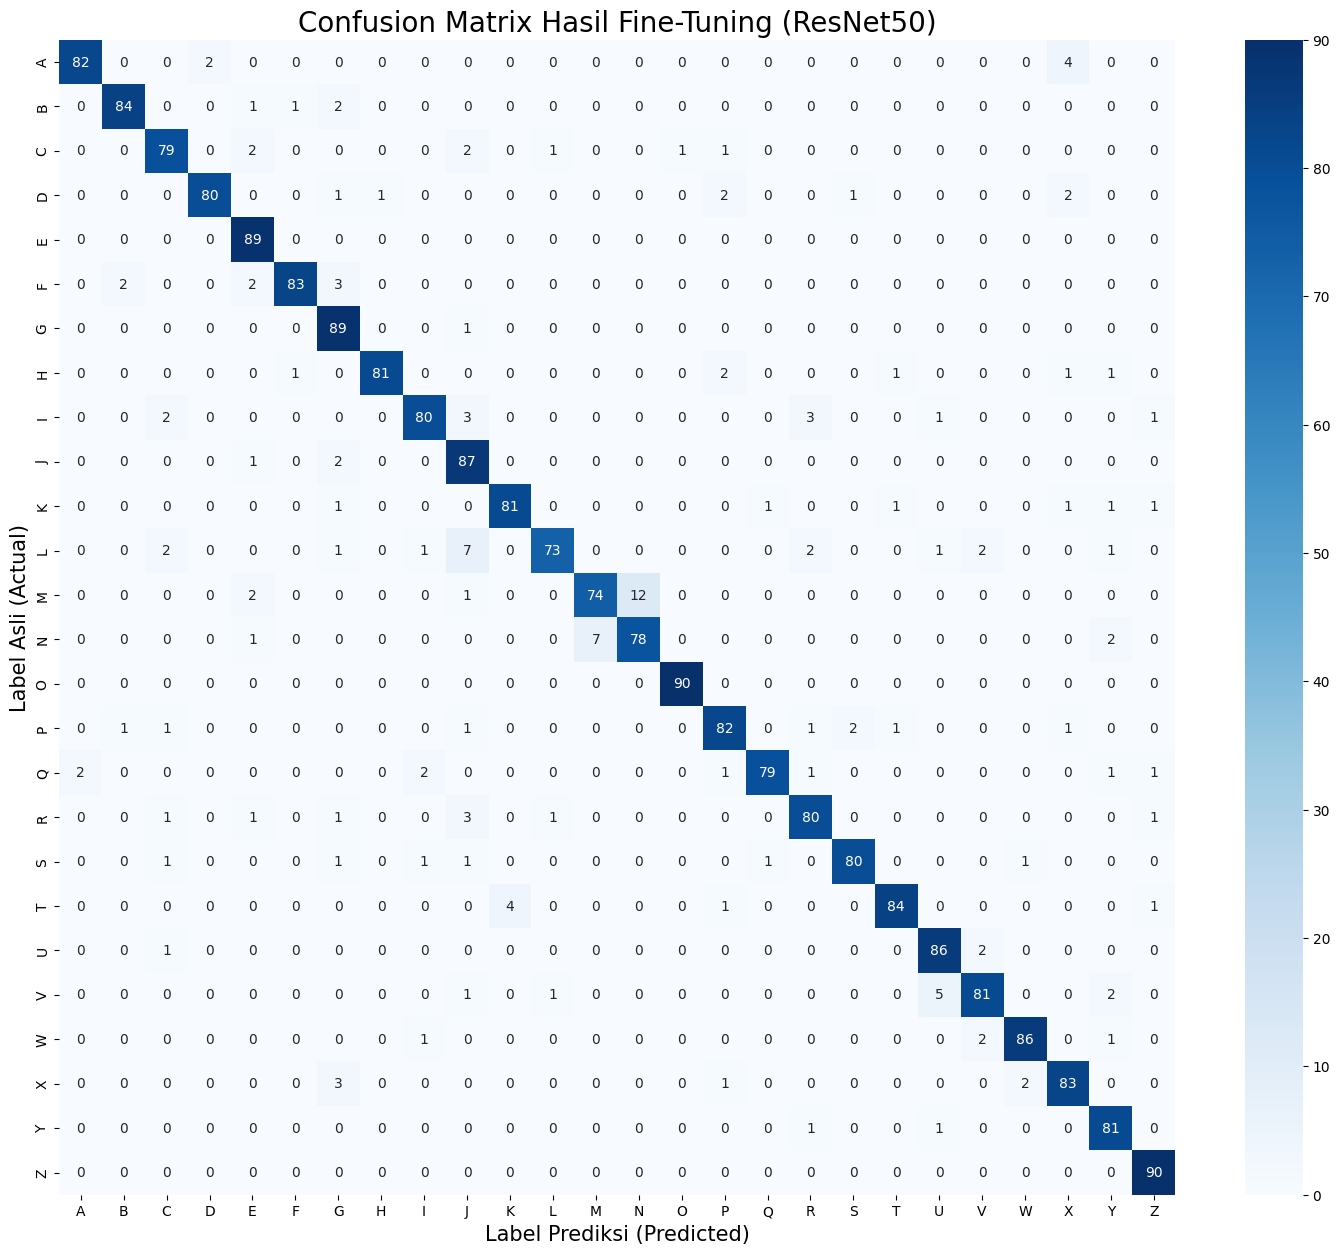


Laporan Klasifikasi Final (Classification Report):

              precision    recall  f1-score   support

           A       0.98      0.93      0.95        88
           B       0.97      0.95      0.96        88
           C       0.91      0.92      0.91        86
           D       0.98      0.92      0.95        87
           E       0.90      1.00      0.95        89
           F       0.98      0.92      0.95        90
           G       0.86      0.99      0.92        90
           H       0.99      0.93      0.96        87
           I       0.94      0.89      0.91        90
           J       0.81      0.97      0.88        90
           K       0.95      0.93      0.94        87
           L       0.96      0.81      0.88        90
           M       0.91      0.83      0.87        89
           N       0.87      0.89      0.88        88
           O       0.99      1.00      0.99        90
           P       0.91      0.91      0.91        90
           Q       0.98     

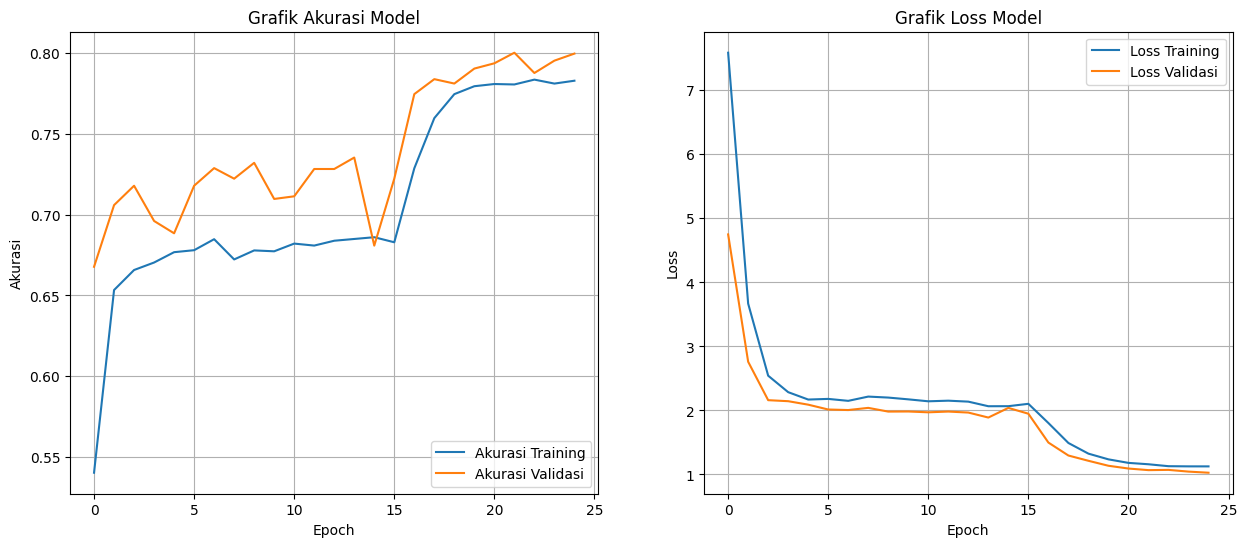

In [55]:
# --- 7.1. Persiapan untuk Visualisasi ---
# Kita perlu mengumpulkan semua label prediksi dan label asli dari data tes.

print("Mengumpulkan prediksi dari data tes untuk visualisasi...")
y_pred_indices = []
y_true_indices = []

# Iterasi melalui seluruh batch pada test_dataset
for images, labels in test_dataset:
    # Lakukan prediksi pada satu batch
    predictions = model.predict(images, verbose=0)
    # Ambil indeks kelas dengan probabilitas tertinggi untuk prediksi
    y_pred_indices.extend(np.argmax(predictions, axis=1))
    # Ambil indeks kelas dari label asli (yang sudah one-hot encoded)
    y_true_indices.extend(np.argmax(labels.numpy(), axis=1))

print("Pengumpulan prediksi selesai.")


# --- 7.2. Membuat Plot Confusion Matrix ---
# Confusion matrix membantu kita melihat di mana model membuat kesalahan.
# Diagonal utama menunjukkan prediksi yang benar.
cm = confusion_matrix(y_true_indices, y_pred_indices)

plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Hasil Fine-Tuning (ResNet50)', fontsize=20)
plt.ylabel('Label Asli (Actual)', fontsize=15)
plt.xlabel('Label Prediksi (Predicted)', fontsize=15)
plt.show()


# --- 7.3. Mencetak Laporan Klasifikasi ---
# Laporan ini memberikan metrik precision, recall, dan f1-score untuk setiap kelas.
print("\nLaporan Klasifikasi Final (Classification Report):\n")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_names))

# Mengambil data akurasi dan loss dari variabel 'history'
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Menentukan jumlah epoch yang sudah berjalan
epochs_range = range(len(acc))

# Membuat figure dengan 2 subplot (1 baris, 2 kolom)
plt.figure(figsize=(15, 6))

# Subplot 1: Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Training')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Grafik Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.grid(True)

# Subplot 2: Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Training')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Grafik Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Menampilkan kedua plot
plt.show()

# UJI COBA MODEL

Model 'bisindo_resnet_finetuned_model.keras' berhasil dimuat.

Memprediksi gambar: body white (1).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Memprediksi gambar: body dot (4).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Memprediksi gambar: body white (2).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


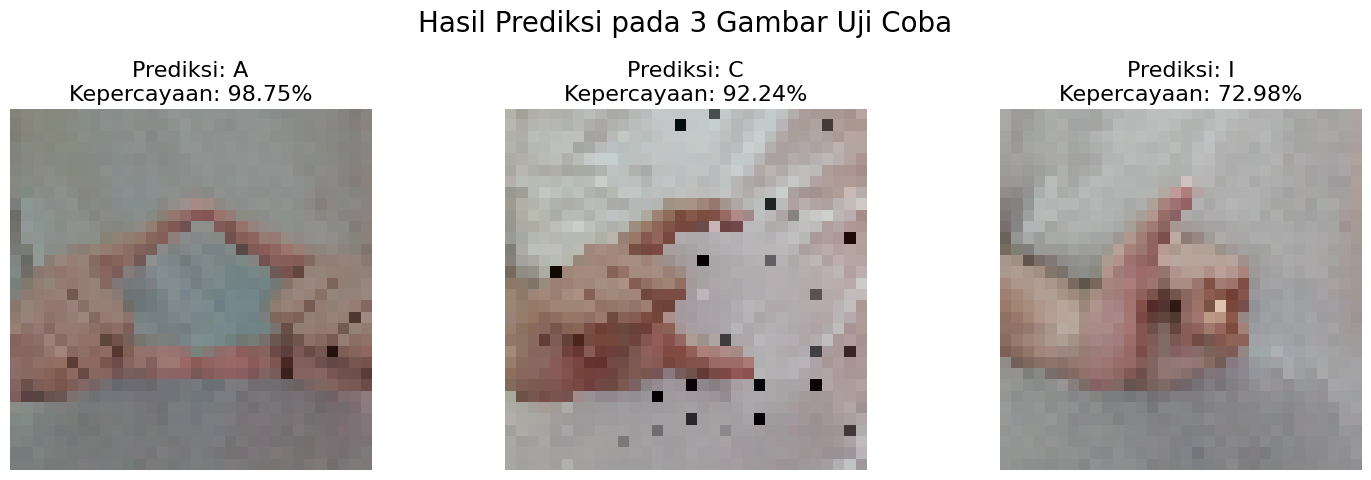

In [64]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 2. Definisikan Variabel yang Dibutuhkan ---
IMG_HEIGHT = 32
IMG_WIDTH = 32
# Nama kelas diambil dari sesi training sebelumnya untuk pemetaan indeks ke huruf
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# --- 3. Muat Model yang Sudah Dilatih ---
nama_file_model = 'bisindo_resnet_finetuned_model.keras' 
loaded_model = load_model(nama_file_model)
print(f"Model '{nama_file_model}' berhasil dimuat.")


try:
    test_dir = '/kaggle/input/indonesian-sign-language-bisindo/bisindo/images/val'
    image_paths = [
        os.path.join(test_dir, '/kaggle/input/alfabet-bisindo/Citra BISINDO/A/body white (1).jpg'), 
        os.path.join(test_dir, '/kaggle/input/alfabet-bisindo/Citra BISINDO/C/body dot (4).jpg'), 
        os.path.join(test_dir, '/kaggle/input/alfabet-bisindo/Citra BISINDO/I/body white (2).jpg')  
    ]

    # Membuat subplot untuk menampilkan 3 gambar dalam satu baris
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Hasil Prediksi pada 3 Gambar Uji Coba', fontsize=20)

    # Lakukan loop untuk setiap path gambar
    for i, image_path in enumerate(image_paths):
        print(f"\nMemprediksi gambar: {os.path.basename(image_path)}...")
        
        # Muat dan Proses Gambar
        img = load_img(image_path, color_mode="rgb", target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        img_for_prediction = np.expand_dims(img_array, axis=0)
        
        # Lakukan Prediksi
        prediction_probabilities = loaded_model.predict(img_for_prediction)
        predicted_index = np.argmax(prediction_probabilities)
        confidence_score = np.max(prediction_probabilities) * 100
        predicted_letter = class_names[predicted_index]
        
        # Tampilkan Hasil pada subplot yang sesuai
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"Prediksi: {predicted_letter}\nKepercayaan: {confidence_score:.2f}%", fontsize=16)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Menyesuaikan layout agar judul utama tidak tumpang tindih
    plt.show()

except NameError:
    print("Pastikan variabel 'test_dir' dan 'class_names' sudah terdefinisi dari sel sebelumnya.")
except FileNotFoundError:
    print(f"ERROR: Salah satu file gambar tidak ditemukan. Periksa kembali daftar 'image_paths'.")
except Exception as e:
    print(f"Terjadi error: {e}")